# AKF

[0.9950495 0.4950495]
[1.00508868 0.50380417]
[0.99502537 0.49500614]
[1.00510133 0.50508893]
[0.99502581 0.49501287]
[1.00510081 0.50508837]
[0.99502631 0.49501337]
[1.00510028 0.50508785]
[0.99502681 0.49501388]
[1.00509976 0.50508733]
[0.99502731 0.49501438]
[1.00509923 0.50508681]
[0.9950278  0.49501488]
[1.00509871 0.50508629]
[0.9950283  0.49501538]
[1.00509819 0.50508577]
[0.9950288  0.49501588]
[1.00509766 0.50508525]
[0.9950293  0.49501638]
[1.00509714 0.50508473]
[0.99502979 0.49501688]
[1.00509662 0.50508421]
[0.99503029 0.49501738]
[1.00509609 0.50508368]
[0.99503079 0.49501788]
[1.00509557 0.50508316]
[0.99503129 0.49501838]
[1.00509505 0.50508264]
[0.99503178 0.49501888]
[1.00509453 0.50508212]
[0.99503228 0.49501938]
[1.005094   0.50508161]
[0.99503278 0.49501988]
[1.00509348 0.50508109]
[0.99503327 0.49502037]
[1.00509296 0.50508057]
[0.99503377 0.49502087]
[1.00509244 0.50508005]
[0.99503426 0.49502137]
[1.00509192 0.50507953]
[0.99503476 0.49502187]
[1.0050914  0.5050

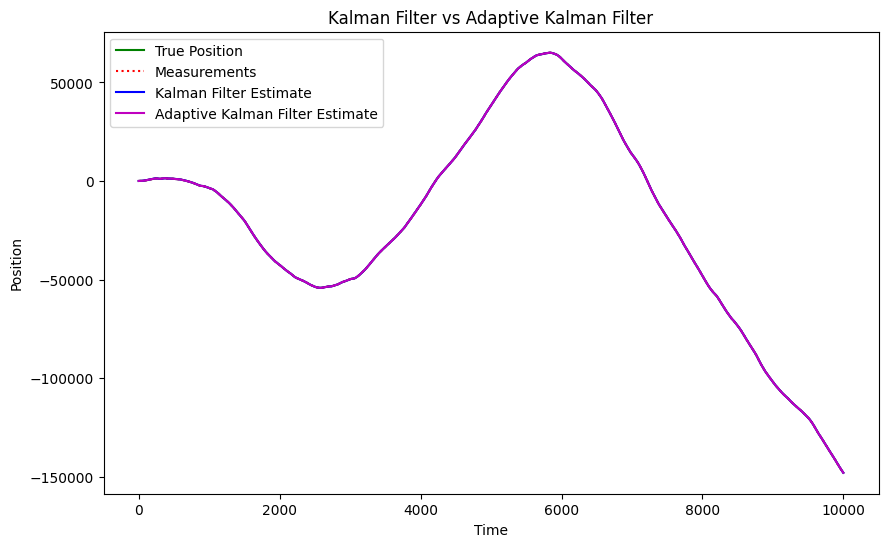

In [3]:
import numpy as np
import matplotlib.pyplot as plt
np.random.seed(20)
# 生成模拟数据，使用协方差生成实际噪声
def generate_data(T, process_noise_var, observation_noise_var):
    x = np.zeros((T, 2))  # [position, velocity]
    z = np.zeros(T)       # observations (only position is observed)
    
    x[0] = [0, 1]  # Initial position 0, velocity 1
    z[0] = x[0, 0] + np.random.normal(0, np.sqrt(observation_noise_var[0]))
    
    for t in range(1, T):
        # 实际生成过程噪声和观测噪声
        process_noise = np.random.normal(0, np.sqrt(process_noise_var[t]), 2)
        observation_noise = np.random.normal(0, np.sqrt(observation_noise_var[t]))
        
        x[t] = np.dot(A, x[t-1]) + process_noise  # 更新状态（带有过程噪声）
        z[t] = x[t, 0] + observation_noise        # 生成观测值（带有观测噪声）
    
    return x, z

# 标准卡尔曼滤波器
def kalman_filter(T, z, Q, R):
    x_hat = np.zeros((T, 2))
    P = np.eye(2) * 1000  # 初始的不确定性
    for t in range(1, T):
        # 预测步骤
        x_hat[t] = np.dot(A, x_hat[t-1])
        P = np.dot(A, np.dot(P, A.T)) + Q

        # 更新步骤
        K = np.dot(P, H.T) / (np.dot(H, np.dot(P, H.T)) + R[t])  # 卡尔曼增益
        x_hat[t] = x_hat[t] + K * (z[t] - np.dot(H, x_hat[t]))    # 更新状态估计
        P = (np.eye(2) - np.dot(K, H)) * P  # 更新误差协方差
    
    return x_hat

# 自适应卡尔曼滤波器
def adaptive_kalman_filter(T, z, Q_initial, R_initial):
    x_hat = np.zeros((T, 2))
    P = np.eye(2) * 100  # 初始的不确定性
    Q = Q_initial.copy()
    R = R_initial.copy()
    
    for t in range(1, T):
        # 预测步骤
        x_hat[t] = np.dot(A, x_hat[t-1])
        P = np.dot(A, np.dot(P, A.T)) + Q

        # 更新步骤
        K = np.dot(P, H.T) / (np.dot(H, np.dot(P, H.T)) + R[t])
        x_hat[t] = x_hat[t] + K * (z[t] - np.dot(H, x_hat[t]))
        P = (np.eye(2) - np.dot(K, H)) * P

        # 自适应调整噪声
        innovation = z[t] - np.dot(H, x_hat[t])
        Q = np.eye(2) * max(np.var(innovation), 1e-4)  # 自适应更新Q
        R[t] = max(np.var(innovation), 1e-4)           # 自适应更新R
        # print(innovation,Q,R)
    
    return x_hat

# 参数设置
T = 10000  # 时间步数
dt = 1.0  # 时间间隔

A = np.array([[1, dt], [0, 1]])  # 状态转移矩阵
H = np.array([1, 0])             # 观测矩阵

# 过程噪声和观测噪声的时变协方差
# process_noise_var = np.linspace(1, 2.0, T)  # 时变过程噪声协方差
# observation_noise_var = np.linspace(1, 2.0, T)  # 时变观测噪声协方差
process_noise_var = np.ones(T)*1  # 时变过程噪声协方差
observation_noise_var = np.ones(T)*1  # 时变观测噪声协方差

# 生成带有实际噪声的数据
x, z = generate_data(T, process_noise_var, observation_noise_var)

# 初始噪声协方差矩阵
Q_initial = np.eye(2) * 1.0
R_initial = np.ones(T) * 1.0

# 应用卡尔曼滤波
x_hat_kf = kalman_filter(T, z, Q_initial, R_initial)

# 应用自适应卡尔曼滤波
x_hat_akf = adaptive_kalman_filter(T, z, Q_initial, R_initial)

# 绘图
plt.figure(figsize=(10, 6))
plt.plot(x[:, 0], label="True Position", color='g')
plt.plot(z, label="Measurements", color='r', linestyle='dotted')
plt.plot(x_hat_kf[:, 0], label="Kalman Filter Estimate", color='b')
plt.plot(x_hat_akf[:, 0], label="Adaptive Kalman Filter Estimate", color='m')
plt.xlabel('Time')
plt.ylabel('Position')
plt.legend()
plt.title('Kalman Filter vs Adaptive Kalman Filter')
plt.show()


# AKF-MAMBA
## 获取数据

In [5]:
# 股票数据
import pandas_datareader.data as web
import datetime
start = datetime.datetime(2014, 1, 1)
end = datetime.datetime(2024, 1, 1)
# end = datetime.datetime.today()
df = web.DataReader('GOOGL', 'stooq', start, end)
df.dropna(inplace=True)
df.sort_index(inplace=True)
print(df)

                Open      High       Low     Close     Volume
Date                                                         
2014-01-02   27.8865   27.9440   27.7065   27.8280   72904600
2014-01-03   27.8750   27.9230   27.6230   27.6250   66708480
2014-01-06   27.8000   27.9715   27.6610   27.9330   70818120
2014-01-07   28.1250   28.4920   28.0290   28.4715  102144520
2014-01-08   28.6500   28.6830   28.3320   28.5310   89706880
...              ...       ...       ...       ...        ...
2023-12-22  140.7700  141.9900  140.7100  141.4900   26532199
2023-12-26  141.5900  142.6800  141.1900  141.5200   16780333
2023-12-27  141.5900  142.0800  139.8860  140.3700   19628618
2023-12-28  140.7800  141.1400  139.7500  140.2300   16045712
2023-12-29  139.6300  140.3600  138.7800  139.6900   18733017

[2516 rows x 5 columns]


In [6]:
import numpy as np

mem_his_days=5
per_days=10

# 股票数据
df['label'] = df['Close'].shift(-per_days)
# 加入噪声
df_da = df.iloc[:,:-2]
# noise = np.random.normal(0, 10, df_da.shape)
# df_da += noise

from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
sca_X = scaler.fit_transform(df.iloc[:,:-2])

from collections import deque
deq = deque(maxlen=mem_his_days)

X = []
for i in sca_X:
    deq.append(list(i))
    if len(deq)==mem_his_days:
        X.append(list(deq))

X_lately = X[-per_days:]
X = X[:-per_days]
y = df['label'].values[mem_his_days-1:-per_days]

import numpy as np
X = np.array(X)
y = np.array(y)
print(X.shape)
print(y.shape)
print(len(X_lately))

(2502, 5, 4)
(2502,)
10


In [7]:
from sklearn.model_selection import train_test_split
X_train,X_test,y_train,y_test = train_test_split(X,y,test_size=0.1)

In [3]:
import torch
from torch.utils.data import DataLoader, TensorDataset

# 训练数据
batch, length, dim = 64, 5, 4
# noise = np.random.normal(sca_X.mean(), 0.05*sca_X.std(), X_train.shape)
# X_train += noise
# X_train_tensor = torch.tensor(X_train, dtype=torch.float32)
# y_train_tensor = torch.tensor(y_train, dtype=torch.float32).view(-1, 1)  # 确保y_train是二维张量
# X_test_tensor = torch.tensor(X_test, dtype=torch.float32)
# y_test_tensor = torch.tensor(y_test, dtype=torch.float32).view(-1, 1)

# # 虚拟数据
X_train_tensor = torch.randn(1351,5,4)
y_train_tensor = torch.randn(1351,1)
X_test_tensor = torch.randn(150,5,4)
y_test_tensor = torch.randn(150,1)

# 定义训练集数据加载器
train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
train_loader = DataLoader(train_dataset, batch_size=batch, shuffle=True,drop_last=False)

# 定义测试集数据加载器
test_dataset = TensorDataset(X_test_tensor, y_test_tensor)
test_loader = DataLoader(test_dataset, batch_size=batch, shuffle=False)

print(X_train_tensor.shape)
print(y_train_tensor.shape)
print(X_test_tensor.shape)
print(y_test_tensor.shape)

e:\program\anaconda3\envs\yk_lstm\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


torch.Size([1351, 5, 4])
torch.Size([1351, 1])
torch.Size([150, 5, 4])
torch.Size([150, 1])


## 模型训练

In [2]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.optim.lr_scheduler as lr_scheduler
from modules.model_mamba import Mamba, ModelArgs,MambaBlock
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error

# 定义模型
class SequenceModel(nn.Module):
    def __init__(self, input_dim, model_dim, state_dim, batch_size,conv_width, expand_factor, output_dim):
        super(SequenceModel, self).__init__()
        args = ModelArgs(d_model=model_dim,n_layer=state_dim,batch_size=batch,d_state=32,
                         d_conv=conv_width,vocab_size=16,expand=expand_factor)
        self.fc1 = nn.Linear(input_dim, model_dim)  # 输入层
        self.mamba = MambaBlock(args)
        self.fc2 = nn.Linear(model_dim*length, output_dim)  # 输出层

    def forward(self, x):
        x = self.fc1(x)
        x = self.mamba(x)
        x = x.view(x.size(0), -1)  # 展平，将 (batch, length, model_dim) 变为 (batch, length * model_dim)
        x = self.fc2(x)
        return x

# 初始化模型
model_mam = SequenceModel(input_dim=dim, model_dim=16, state_dim=16, batch_size=batch,
                          conv_width=4, expand_factor=2, output_dim=1)
print(model_mam)
# 定义损失函数和优化器
criterion = nn.MSELoss()
optimizer = optim.Adam(model_mam.parameters(), lr=1e-4)
# 动态学习率
# scheduler = lr_scheduler.StepLR(optimizer, step_size=20, gamma=0.6)
# 训练模型
losses_mam = []
mse_test_mam = []
num_epochs = 10
for epoch in range(num_epochs):
    # 训练
    model_mam.train()
    for x_batch, y_batch in train_loader:
        # print(x_batch.shape,y_batch.shape)
        y_pred = model_mam(x_batch)
        loss = criterion(y_pred, y_batch)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
    losses_mam.append(loss.item())
    # # 评价
    # model_mam.eval()
    # y_pred_batch = y_test_tensor
    # with torch.no_grad():
    #     for inputs, labels in test_loader:
    #         outputs = model_mam(inputs)
    #         y_pred_batch = torch.cat((y_pred_batch,outputs),dim=0)
    # mse = mean_squared_error(y_pred_batch[:y_test_tensor.shape[0]] , y_pred_batch[y_test_tensor.shape[0]:])
    # 评价
    model_mam.eval()
    y_pred = []
    for x_test_batch,y_test_batch in test_loader:
        with torch.no_grad():
            y_pred_batch = model_mam(x_test_batch)
            y_pred.append(y_pred_batch)
    y_pred = torch.cat(tuple(y_pred),dim=0)
    mse = mean_squared_error(y_pred , y_test_tensor)

    # 打印
    if (epoch + 1) % 5 == 0:
        print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {loss.item():.4f}, \t Mse:{mse:.4f}')


SequenceModel(
  (fc1): Linear(in_features=4, out_features=16, bias=True)
  (mamba): MambaBlock(
    (in_proj): Linear(in_features=16, out_features=64, bias=False)
    (conv1d): Conv1d(32, 32, kernel_size=(4,), stride=(1,), padding=(3,), groups=32)
    (x_proj): Linear(in_features=32, out_features=65, bias=False)
    (dt_proj): Linear(in_features=1, out_features=32, bias=True)
    (out_proj): Linear(in_features=32, out_features=16, bias=False)
  )
  (fc2): Linear(in_features=80, out_features=1, bias=True)
)
Epoch [5/10], Loss: 1.3380, 	 Mse:1.0764
Epoch [10/10], Loss: 0.6427, 	 Mse:1.0743


In [3]:
print(model_mam.mamba.deltaA.shape)

torch.Size([22, 5, 32, 32])


In [4]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.optim.lr_scheduler as lr_scheduler
from modules.model_deltaLsize_1xn_in_scan import Mamba, ModelArgs,MambaBlock
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error

# 定义模型
class SequenceModel(nn.Module):
    def __init__(self, input_dim, model_dim, state_dim, batch_size, conv_width, expand_factor, output_dim):
        super(SequenceModel, self).__init__()
        args = ModelArgs(d_model=model_dim,n_layer=state_dim,batch_size=batch,d_state=16,
                         d_conv=conv_width,vocab_size=16,expand=expand_factor)
        self.fc1 = nn.Linear(input_dim, model_dim)  # 输入层
        self.mamba = MambaBlock(args)
        self.fc2 = nn.Linear(model_dim*length, output_dim)  # 输出层

    def forward(self, x, loss_mem=None):
        self.m_in = self.fc1(x)
        self.m_ot = self.mamba(self.m_in, loss_mem)
        self.x0 = self.m_ot.view(self.m_ot.size(0), -1)  # 展平，将 (batch, length, model_dim) 变为 (batch, length * model_dim)
        x = self.fc2(self.x0)
        return x
# 初始化模型
model_kam = SequenceModel(input_dim=dim, model_dim=8, expand_factor=2,
                            state_dim=16, batch_size=batch,
                            conv_width=4, output_dim=1)
print(model_kam)
# 定义损失函数和优化器
criterion = nn.MSELoss()
optimizer = optim.Adam(model_kam.parameters(), lr=1e-4)
# 动态学习率
# scheduler = lr_scheduler.StepLR(optimizer, step_size=20, gamma=0.6)
# 定义hook
latest_gradient = torch.zeros(batch,length,64)
gradient_list = [None]*50
def hook_fn(grad):
    global latest_gradient
    latest_gradient = grad if grad.shape[0]==batch else latest_gradient
    # latest_gradient = grad

    
# 训练模型
losses_kam = []
mse_test_kam = []
num_epochs = 10
for epoch in range(num_epochs):
    # 训练
    model_kam.train()
    for batch_index,(x_batch, y_batch) in enumerate(train_loader):
        y_pred = model_kam(x_batch,gradient_list[batch_index])
        loss = criterion(y_pred, y_batch)
        hook_handle = model_kam.mamba.intermediate_output.register_hook(hook_fn)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        # print(batch_index,latest_gradient.shape)
        gradient_list[batch_index] = latest_gradient

    losses_kam.append(loss.item())
    # 评价
    model_kam.eval()
    y_pred_list = []
    y_test_list = []
    for x_test_batch,y_test_batch in test_loader:
        y_test_list.append(y_test_batch)
        with torch.no_grad():
            y_pred_batch = model_kam(x_test_batch)
            y_pred_list.append(y_pred_batch)
    y_pred_lists = torch.cat(tuple(y_pred_list),dim=0)
    y_test_lists = torch.cat(tuple(y_test_list),dim=0)
    mse = mean_squared_error(y_pred_lists , y_test_lists)
    mse_test_kam.append(mse)

    # hook_handle.remove()
    # 打印
    if (epoch + 1) % 5 == 0:
        # print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {loss.item():.4f}')
        print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {loss.item():.4f}, \t Mse:{mse:.4f}')
hook_handle.remove()

SequenceModel(
  (fc1): Linear(in_features=4, out_features=8, bias=True)
  (mamba): MambaBlock(
    (in_proj): Linear(in_features=8, out_features=32, bias=False)
    (conv1d): Conv1d(16, 16, kernel_size=(4,), stride=(1,), padding=(3,), groups=16)
    (x_proj): Linear(in_features=16, out_features=33, bias=False)
    (dt_proj): Linear(in_features=1, out_features=16, bias=True)
    (out_proj): Linear(in_features=16, out_features=8, bias=False)
  )
  (fc2): Linear(in_features=40, out_features=1, bias=True)
)
Epoch [5/10], Loss: 1.7055, 	 Mse:1.0406
Epoch [10/10], Loss: 2.5300, 	 Mse:1.0410


In [19]:
print(model_kam.mamba.deltaA.shape)
print(model_kam.mamba.deltaL.shape)
print(model_kam.mamba.C.shape)
# model_kam.mamba.delta.shape,model_kam.mamba.L.shape

torch.Size([22, 5, 16, 16])
torch.Size([22, 5, 16, 16])
torch.Size([22, 5, 16])


In [5]:
import einops
import numpy as np
b, l, d_in, n = 22,5,16,16
Luen_grad = torch.zeros(b,l,16)
x = torch.zeros((b, d_in, n))
A = model_kam.mamba.deltaA
Bu = model_kam.mamba.deltaB_u
deltaLgrad = einops.einsum(model_kam.mamba.deltaL,Luen_grad,'b l d_in n, b l d_in -> b l d_in n')
C = model_kam.mamba.C
ys = []
for i in range(l):
    x = A[:,i]*x+Bu[:,i]+deltaLgrad[:,i]
    y = einops.einsum(x, C[:, i], 'b d_in n, b n -> b d_in')
    ys.append(y)
print(ys[0].shape)

torch.Size([22, 16])


In [19]:
import einops
import numpy as np
b, l, d_in, n = 22,5,16,16
Luen_grad = torch.zeros(b,l,16)
x = torch.zeros((b, d_in, n))
A = model_kam.mamba.deltaA
Bu = model_kam.mamba.deltaB_u
deltaLgrad = einops.einsum(model_kam.mamba.deltaL,Luen_grad,'b l d_in n, b l d_in -> b l d_in n')
C = model_kam.mamba.C
P = torch.eye(16)
Q = torch.eye(16)
R = torch.eye(1)
ys = []
for i in range(l):
    x = A[:,i]*x+Bu[:,i]
    for j in range(b):
        P = (A[j,i]@P)@A[j,i].T+Q
        Ct = C[j,i].view(1,16)
        K = P*torch.inverse(Ct@P@Ct.T+R)
        P = (torch.eye(16)-einops.einsum(K, Ct, 'd_in n,o n -> d_in n'))@P

    x = x + einops.einsum(K, Luen_grad[:,i], 'd_in n,b d_in ->b d_in n')

    y = einops.einsum(x, C[:, i], 'b d_in n, b n -> b d_in')
    ys.append(y)
print(ys[0].shape)

torch.Size([22, 16])
